In [1]:
import os
import flopy
import matplotlib.pyplot as plt
from flopy.plot import PlotMapView
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.discretization import VertexGrid
from flopy.plot import styles
from flopy.export.vtk import Vtk
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
import shapefile
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from dany import fill_sinks, fill_nan_values, FlowDirections, PrmsStreams, Sfr6

from gsflow.builder import GenerateFishnet

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version

In [2]:
ws = os.path.join(".")
data_ws = os.path.join(ws, "..", "data")
dem_file = os.path.join(data_ws, "dem.img")
pour_point = os.path.join(data_ws, "model_points.shp")

Generate a `StructuredGrid` instance via pyGSFLOW's `GenerateFishnet` class 

In [3]:
cellsize = 50
sgrid = GenerateFishnet(dem_file, xcellsize=cellsize, ycellsize=cellsize)
sgrid

xll:214270.0; yll:4366610.0; rotation:0.0; units:undefined; lenuni:0

Use FloPy's `Raster` class to resample the DEM to the model grid

In [4]:
rstr = flopy.utils.Raster.load(dem_file)
dem = rstr.resample_to_grid(sgrid, rstr.bands[0], method="min")
dem[dem == rstr.nodatavals[0]] = np.nan

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\rasterstats\io.py:17: DeprecationWarning: ReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import ReadingError


Condition the DEM and run flow accumulation

In [5]:
conditioned_dem = fill_sinks(sgrid, dem)
fdir = FlowDirections(sgrid, conditioned_dem)
fdir_arr = fdir.flow_directions()
facc = fdir.flow_accumulation()

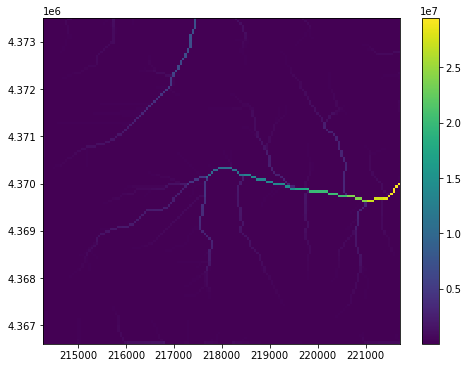

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
lfacc = np.log10(facc)
pc = pmv.plot_array(facc)
# pmv.plot_grid()
plt.colorbar(pc);

Read in the gage location at the end of the basin and delineate the watershed

In [7]:
gdf = gpd.read_file(pour_point)
pploc = gdf.geometry.values[0]
type(pploc)
pploc.__geo_interface__

{'type': 'Point', 'coordinates': (221298.4058475063, 4369674.979622432, 0.0)}

In [8]:
watershed = fdir.get_watershed_boundary(pploc)
print(facc.shape, watershed.shape)
facc[watershed == 0] = np.nan

(138, 149) (138, 149)


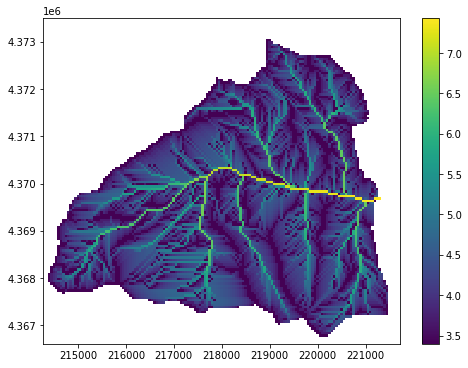

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
lfacc = np.log10(facc)
pc = pmv.plot_array(lfacc)
# pmv.plot_grid()
plt.colorbar(pc);

Delineate the structured stream locations and create vectors

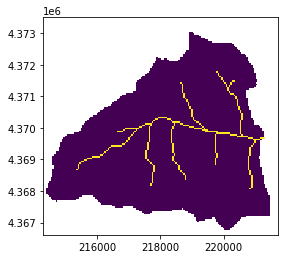

In [10]:
strms = PrmsStreams(sgrid, fdir)
strm_array = strms.delineate_streams(contrib_area=810000).astype(float)
strm_array[watershed == 0] = np.nan

pmv = PlotMapView(modelgrid=sgrid)
pmv.plot_array(strm_array)

vectors = strms.create_stream_vectors(strm_array)

Plot these vectors with the stream array

In [11]:
geom = [LineString(v) for v in vectors.values()]
segs = [k for k in vectors.keys()]
gdf = gpd.GeoDataFrame({"geometry": geom, "segments": segs})
gdf.set_crs(epsg=26911, inplace=True)
gdf.to_file("streams.shp")
gdf = gdf.dissolve()
gdf["geometry"] = gdf.geometry.buffer(50, cap_style=2, join_style=3)
# gdf.segments.max() # head()

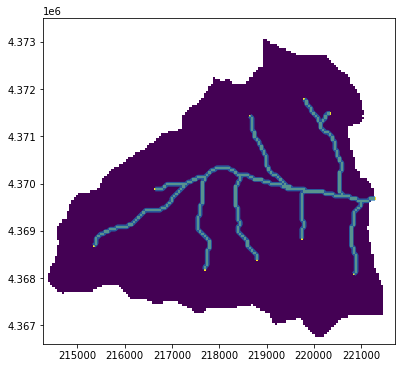

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
strm_array[watershed == 0] = np.nan
pc = pmv.plot_array(strm_array)
gdf.plot(ax=ax, alpha=0.75);

Create a geodataframe of the active watershed and dissolve it

In [13]:
sgdf = sgrid.geo_dataframe
iloc = np.where(watershed.ravel() > 0)[0]
sgdf = sgdf.iloc[iloc]
sgdf = sgdf.dissolve()
sgdf.set_crs(epsg=26911, inplace=True)
sgdf.to_file("watershed_boundary.shp")

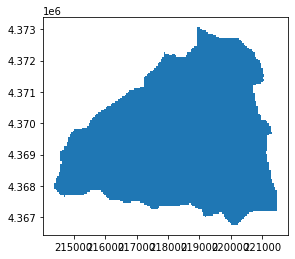

In [14]:
sgdf.plot();

Trim the buffered stream vectors by overlaying with the active watershed

In [15]:
igdf = gpd.overlay(gdf, sgdf, how="intersection")

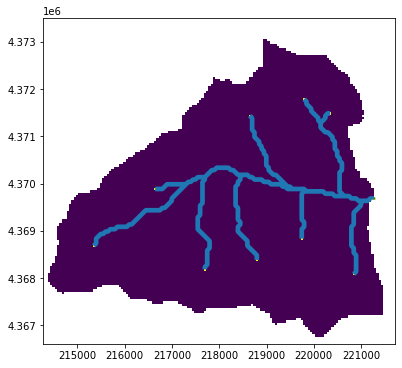

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
strm_array[watershed == 0] = np.nan
pc = pmv.plot_array(strm_array)
igdf.plot(ax=ax);

Generate a triangular mesh using the `Triangle` module

Note: Must define a watershed point `wsloc` and a stream refinement point `srloc`

In [17]:
wsloc = (220000, 4368000)
srloc = (219250, 4370000)

In [18]:
tri_ws = os.path.join(data_ws, "tri_temp")
tri = flopy.utils.triangle.Triangle(angle=30, model_ws=tri_ws)
tri.add_polygon(sgdf.geometry.values[0])
tri.add_polygon(gdf.geometry.values[0], ignore_holes=True)
tri.add_region(wsloc, 0, maximum_area=100*100*3)
tri.add_region(srloc, 1, maximum_area=40*40)
tri.build()

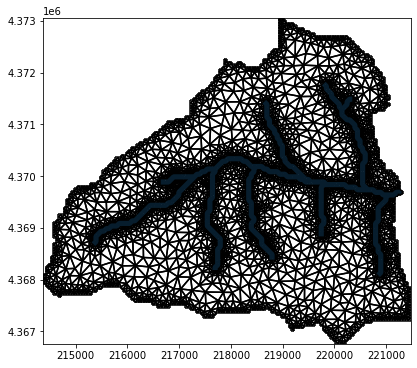

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
tri.plot(ax=ax)
igdf.geometry.plot(ax=ax, alpha=0.25, zorder=5);

Now generate a voronoi mesh from the triangular mesh

In [20]:
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
vgrid = VertexGrid(nlay=1, **gridprops)

verts = np.array(gridprops["vertices"])[:, 1:]

check = np.unique(verts, axis=0)

if verts.shape != check.shape:
    # duplicate vertices!!!!! We need to fix this somehow!
    # potentially create a search and replace operation. It seems likely that some voronoi cells have duplicate verts.
    print(verts.shape, check.shape)

(9637, 2) (9021, 2)


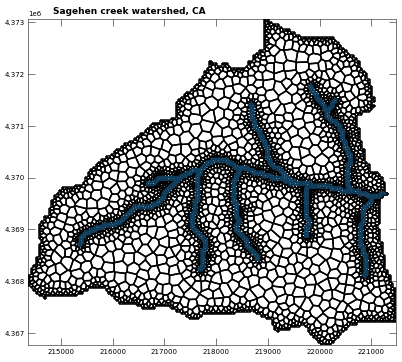

In [21]:
with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(8, 6))
    pmv = PlotMapView(modelgrid=vgrid, ax=ax)
    pmv.plot_grid(color="k")
    igdf.geometry.plot(ax=ax, alpha=0.50, zorder=5)
    styles.heading(ax=ax, heading="        Sagehen creek watershed, CA")
    # plt.savefig(os.path.join("..", "figures", "sagehen_voronoi.png"));

Now we can begin the process of performing raster resampling and flow accumulation on the voronoi grid

In [22]:
raster = flopy.utils.Raster.load(dem_file)
dem = raster.resample_to_grid(vgrid, band=raster.bands[0], method="min")
dem = np.where(dem == raster.nodatavals[0], np.nan, dem)

xy = list(zip(*pploc.coords.xy))[0]
ppnode = vgrid.intersect(*xy)
dem[ppnode] = np.nanmin(dem) - 1

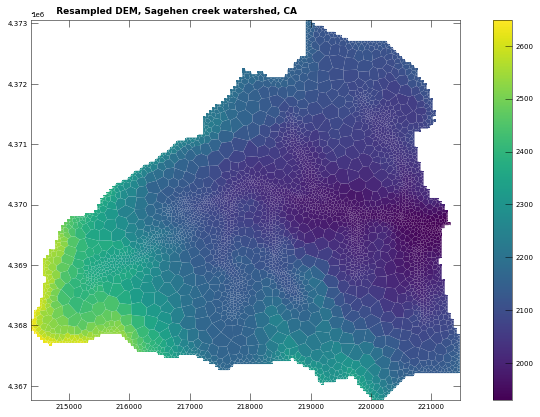

In [23]:
filled_dem = fill_nan_values(vgrid, dem)
conditioned_dem = fill_sinks(vgrid, filled_dem)

with styles.USGSPlot():
    fig, ax = plt.subplots(figsize=(12, 7))
    pmv = PlotMapView(modelgrid=vgrid)
    pc = pmv.plot_array(conditioned_dem)
    pmv.plot_grid
    plt.colorbar(pc)
    styles.heading(ax=ax, letter="      ", heading="      Resampled DEM, Sagehen creek watershed, CA")
    # plt.savefig(os.path.join("..", "figures", "sagehen_dem.png"));

vgrid._top = conditioned_dem
vgrid._botm = np.array([conditioned_dem]) - 300
# vtk = Vtk(modelgrid=vgrid, vertical_exageration=5)
# vtk.add_array(conditioned_dem, "top")
# vtk.write("../shvtk/sagehen")

In [24]:
# perform area based flow accumulation
fdir = FlowDirections(vgrid, conditioned_dem)
fdir_arr = fdir.flow_directions()
facc = fdir.flow_accumulation()
# perform cellular flow accumulation
fdir2 = FlowDirections(vgrid, conditioned_dem)
fdir2_arr = fdir2.flow_directions()
facc2 = fdir2.flow_accumulation(as_cells=True)

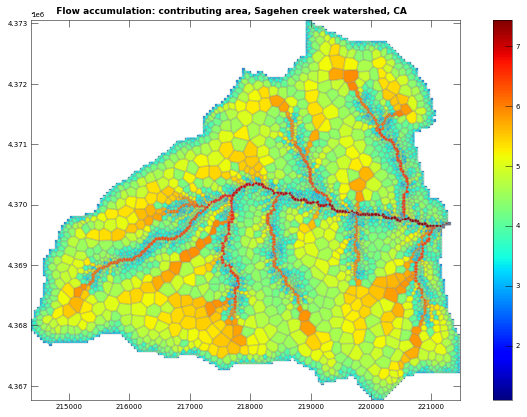

In [25]:
with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(12, 7))
    pmv = PlotMapView(modelgrid=vgrid)
    lfacc = np.log10(facc)
    pc = pmv.plot_array(lfacc, cmap="jet")
    # pc = pmv.plot_array(conditioned_dem, alpha=1.0, cmap="jet", vmin=1900, vmax=2000)
    pmv.plot_grid(alpha=0.2)
    plt.colorbar(pc)
    styles.heading(ax=ax, letter="      ", heading="      Flow accumulation: contributing area, Sagehen creek watershed, CA")
    # plt.savefig(os.path.join("..", "figures", "sagehen_flow_accumulation.png"));

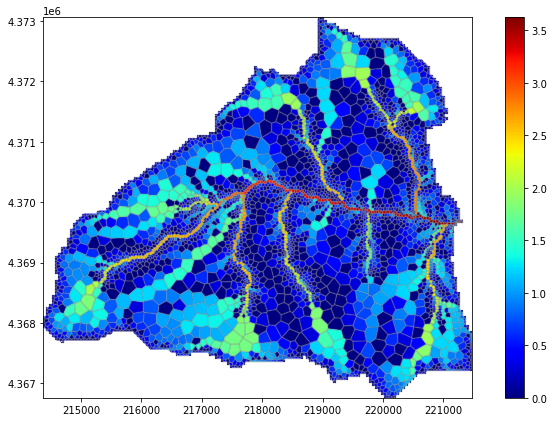

In [26]:
fig, ax = plt.subplots(figsize=(12, 7))
pmv = PlotMapView(modelgrid=vgrid)
lfacc2 = np.log10(facc2)
pc = pmv.plot_array(lfacc2, alpha=1.0, cmap="jet")
pmv.plot_grid(alpha=0.2)
plt.colorbar(pc);

Threshold the unstructured stream network by area based flow accumulation

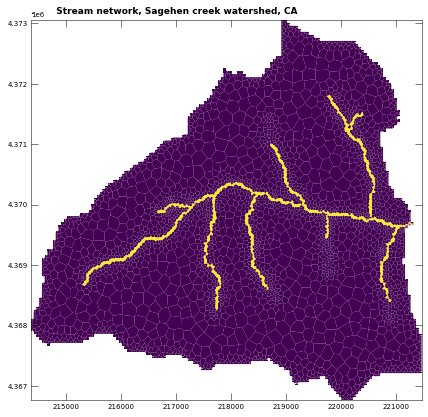

In [27]:
strms = PrmsStreams(vgrid, fdir)
stream_array = strms.delineate_streams(contrib_area=1e6)

with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(7, 7))
    pmv = PlotMapView(modelgrid=vgrid, ax=ax)
    pc = pmv.plot_array(stream_array)
    styles.heading(ax=ax, letter="      ", heading="      Stream network, Sagehen creek watershed, CA")
    # plt.savefig(os.path.join("..", "figures", "sagehen_stream_network.png"));

Threshold the cellular based flow accumulation for comparison

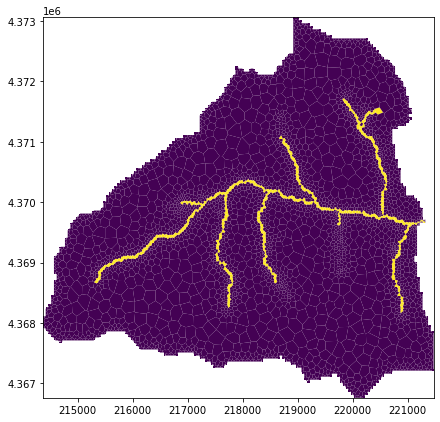

In [28]:
strms2 = PrmsStreams(vgrid, fdir2)
stream_array2 = strms2.delineate_streams(contrib_area=1.2e2)

fig, ax = plt.subplots(figsize=(7, 7))
pmv = PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(stream_array2);

Create a graph of stream linkages with `PrmsStreams`

In [29]:
strm_conn = strms.get_stream_connectivity(stream_array, group_segments=True)
print(strm_conn)
print(np.min(stream_array), np.max(stream_array))

{14: 15, 9: 10, 8: 12, 6: 7, 5: 17, 4: 11, 3: 13, 2: 15, 1: 7, 15: 16, 18: 18, 16: 17, 13: 16, 10: 11, 11: 12, 17: 18, 7: 10, 12: 13}
0 18


generate many to one cascade linkages with `PrmsStreams`

In [30]:
hru_up, hru_down, hru_pct_up, hru_strmseg_down = strms.get_cascades(stream_array=stream_array)

or generate many to many cascade linkages with `PrmsStreams`

In [31]:
hru_up, hru_down, hru_pct_up, hru_strmseg_down = strms.get_cascades(stream_array=stream_array, many2many=True)

Slopes for all cells can be returned too.

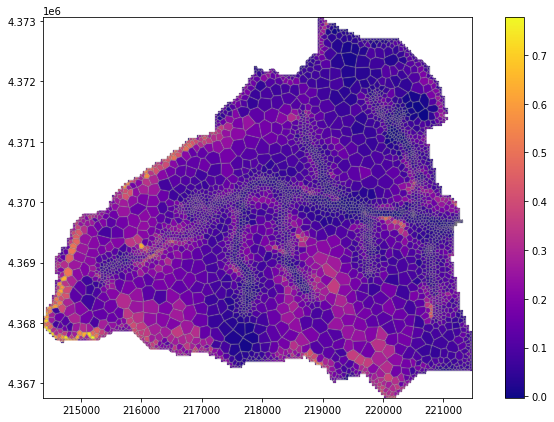

In [32]:
slope = fdir.slope

fig, ax = plt.subplots(figsize=(12, 7))
pmv = PlotMapView(modelgrid=vgrid)
pc = pmv.plot_array(slope, alpha=1.0, cmap="plasma")
pmv.plot_grid(alpha=0.2)
plt.colorbar(pc);

Aspect can be calculated from flow directions

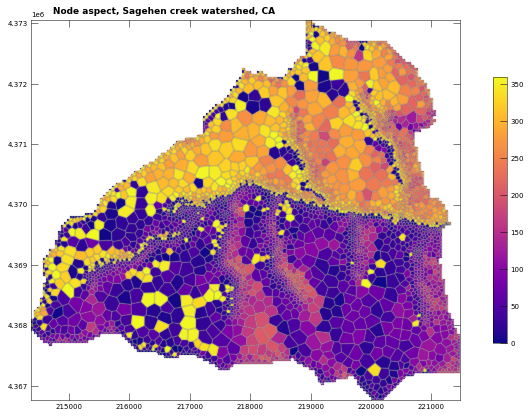

In [33]:
aspect = fdir.aspect

with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(12, 7))
    pmv = PlotMapView(modelgrid=vgrid)
    pc = pmv.plot_array(aspect, alpha=1.0, cmap="plasma")
    pmv.plot_grid(alpha=0.2)
    plt.colorbar(pc, shrink=0.7)
    styles.heading(ax=ax, heading="       Node aspect, Sagehen creek watershed, CA")
    # plt.savefig(os.path.join("..", "figures", "sagehen_aspect.png"));

Unit circle vectors can also be plotted

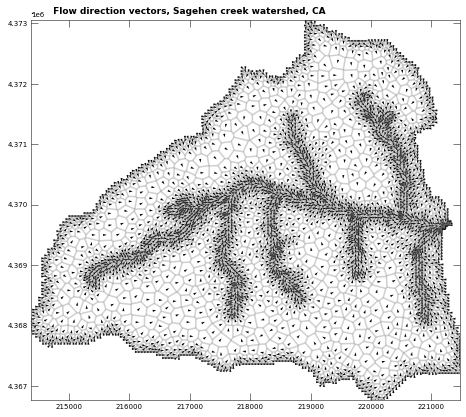

In [34]:
u, v = fdir.vectors

cell = np.zeros(vgrid.shape[1:], dtype=int)
cell[2] = 1

with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(12, 7))
    pmv = PlotMapView(modelgrid=vgrid)
    pc = pmv.plot_vector(u, v)
    # pc = pmv.plot_array(cell, masked_values=[0])
    pmv.plot_grid(alpha=0.2)
    # plt.colorbar(pc)
    styles.heading(ax=ax, letter="            ", heading="     Flow direction vectors, Sagehen creek watershed, CA")
    # plt.savefig(os.path.join("..", "figures", "sagehen_vectors.png"));

We can also generate the input data structure for MODFLOW-6's SFR package

In [35]:
sfr_strms = Sfr6(vgrid, fdir)
stream_array = sfr_strms.delineate_streams(contrib_area=1e6)
stream_graph = sfr_strms.get_stream_connectivity()
connectiondata = sfr_strms.connectiondata()

In [36]:
connectiondata

[(1, -11),
 (2, -76),
 (3, -4),
 (4, 3, -5),
 (5, 4, -6),
 (6, 5, -8),
 (7, -10),
 (8, 6, -12),
 (9, -252),
 (10, 7, -33),
 (11, 1, -20),
 (12, 8, -13),
 (13, 12, -14),
 (14, 13, -82),
 (15, -16),
 (16, 15, -69),
 (17, -18),
 (18, 17, -19),
 (19, 18, -77),
 (20, 11, -21),
 (21, 20, -22),
 (22, 21, -23),
 (23, 22, -24),
 (24, 23, -25),
 (25, 24, -26),
 (26, 25, -27),
 (27, 26, -28),
 (28, 27, -29),
 (29, 28, -30),
 (30, 29, -31),
 (31, 30, -32),
 (32, 31, -171),
 (33, 10, -34),
 (34, 33, -35),
 (35, 34, -36),
 (36, 35, -37),
 (37, 36, -38),
 (38, 37, -39),
 (39, 38, -40),
 (40, 39, -41),
 (41, 40, -42),
 (42, 41, -74),
 (43, -44),
 (44, 43, -45),
 (45, 44, -46),
 (46, 45, -47),
 (47, 46, -48),
 (48, 47, -49),
 (49, 48, -50),
 (50, 49, -51),
 (51, 50, -52),
 (52, 51, -53),
 (53, 52, -54),
 (54, 53, -55),
 (55, 54, -56),
 (56, 55, -57),
 (57, 56, -58),
 (58, 57, -59),
 (59, 58, -60),
 (60, 59, -61),
 (61, 60, -62),
 (62, 61, -63),
 (63, 62, -64),
 (64, 63, -65),
 (65, 64, -66),
 (66, 65, 